# Finding important ROIs implicated in memory

Using Neurosynth, search term = "memory": Use the uniformity test map, which displays brain regions that are consistently active in studies that load highly on the term memory.

   1. Use `fslmaths` to threshold z-values using 98th percentile of the positive values
   2. Use `3dClusterize` to find peak

In [1]:
%%bash
  
path=/Users/TienTong/Desktop/utdallas_demo/code/neurosynth
fslmaths \
  $path/memory_uniformity-test_z_FDR_0.01.nii.gz \
  -thr 0 \
  $path/memory_uniformity-test_z_FDR_0.01_pos.nii.gz

fslmaths \
  $path/memory_uniformity-test_z_FDR_0.01_pos.nii.gz \
  -thrp 98 \
  $path/memory_uniformity-test_z_FDR_0.01_pos_98.nii.gz

# 3dClusterize -nosum -1Dformat -inset \
#   $path/memory_uniformity-test_z_FDR_0.01_pos_98.nii.gz \
#   -idat 0 -ithr 0 -NN 2 -clust_nvox 40 -bisided -0.0001 0.0001 \
#   -orient LPI -1Dformat

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


,#Voxels,x,y,z,index,regions
0,4134,-32,22,-6,1,left_Insula
1,2485,-34,-50,44,2,left_IPL
2,2007,-26,-18,-18,3,left_Hippocampus
3,1871,2,18,44,4,SMA
4,1699,38,-48,44,5,right_IPL
5,1514,48,10,28,6,right_IFG
6,1286,24,-10,-16,7,right_Hippocampus


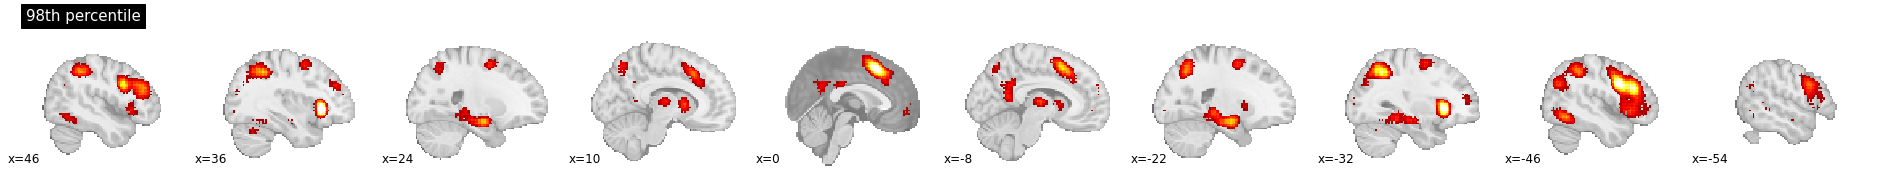

In [2]:
from nilearn.image import threshold_img
from nilearn import plotting
import pandas as pd

path='/Users/TienTong/Desktop/utdallas_demo/code/neurosynth'
memory_neurosynth=path+'/memory_uniformity-test_z_FDR_0.01_pos_98.nii.gz'

plotting.plot_stat_map(memory_neurosynth, display_mode='x', cut_coords=10,
                       title='98th percentile', colorbar=False)

memory_peak = pd.read_csv(path+'/memory_peak.txt', sep='\t')
memory_peak_undump = memory_peak[['x','y','z','index']]
memory_peak_undump.to_csv(path+'/memory_peak_undump.txt', sep=' ', index=False)
memory_peak[['index', 'regions']].to_csv(path+'/atlas.tsv', sep='\t', index=False)

memory_peak

### Use `3dUndump` to create 8-mm radius spheres @ peak z-values from Neurosynnth

In [3]:
%%bash

path=/Users/TienTong/Desktop/utdallas_demo/code/neurosynth
template=/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz

3dUndump \
  -prefix ${path}/memory_peak.nii.gz \
  -master ${template} \
  -srad 8 \
  -xyz ${path}/memory_peak_undump.txt
  

++ 3dUndump: AFNI version=AFNI_21.2.05 (Aug 22 2021) [64-bit]
++ Starting to fill via -xyz coordinates
++ Total number of voxels filled = 1799
++ Wrote out dataset /Users/TienTong/Desktop/utdallas_demo/code/neurosynth/memory_peak.nii.gz


# Beta series

Beta series steps (picture by Kimberly L Ray, citation: 10.1016/j.nicl.2017.05.001)

<img src="steps.png" alt="Beta Series Steps" style="width: 300px;"/>

### Use AFNI `3dDeconvolve` to get beta series of each condition (prospective face/scene memory, 2-back lexical decision). Notes on getting these series pasted below:

```
[-stim_times_IM k tname Rmodel]                                        
   Similar, but each separate time in 'tname' will get a separate      
   regressor; 'IM' means 'Individually Modulated' -- that is, each     
   event will get its own amplitude estimated.  Presumably you will    
   collect these many amplitudes afterwards and do some sort of        
   statistics or analysis on them. 
```


### Make AFNI event timing files


In [4]:
import os
import pandas as pd

bids = '/Users/TienTong/Desktop/utdallas_demo/data'
events_em_sub1_run1 = pd.read_csv(os.path.join(bids, 'sub-01/func/sub-01_task-em_run-01_events.tsv'),
                                 sep='\t')
for cond in ['face', 'scene', 'lexdec']:
    out_file='sub-01/func/sub-01_task-em_run-01_events-' + cond + '.txt'
    pd.DataFrame(events_em_sub1_run1.loc[events_em_sub1_run1.categ==cond, 
                                         'onset']).transpose().to_csv(
        os.path.join(bids, out_file), sep=' ', index=False, header=False)

### Make AFNI confound files

In [5]:
fmriprep = '/Users/TienTong/Desktop/utdallas_demo/derivatives/fmriprep'

confound_em_sub1_run1 = pd.read_csv(os.path.join(fmriprep, 
                                                 'sub-01/func/sub-01_task-em_run-1_desc-confounds_timeseries.tsv'),
                                 sep='\t')

for confound in ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']:
    out_file='sub-01/func/sub-01_task-em_run-1_desc-confounds_timeseries-' + confound + '.txt'
    confound_em_sub1_run1[[confound]].to_csv(
        os.path.join(fmriprep, out_file), sep=' ', index=False, header=False)
                 

### Run 3dDeconvolve

`tcsh 03_3dDeconvolve_betaseries.csh`

```

3dDeconvolve -input $input                                                   \
    -automask						                                        \
    -polort 2                                                                \
    -num_stimts 9                                                            \
    -stim_times_IM 1 $face_stim 'SPMG2'                                      \
    -stim_label 1 face                                                       \
    -stim_times_IM 2 $scene_stim 'SPMG2'                                     \
    -stim_label 2 scene                                                      \
    -stim_times_IM 3 $lexdec_stim 'SPMG2'                                    \
    -stim_label 3 lexdec                                                     \
    -stim_file 4 $transx_file -stim_base 4 -stim_label 4 trans_x             \
    -stim_file 5 $transy_file -stim_base 5 -stim_label 5 trans_y             \
    -stim_file 6 $transz_file -stim_base 6 -stim_label 6 trans_z             \
    -stim_file 7 $rotx_file -stim_base 7 -stim_label 7 rot_x                 \
    -stim_file 8 $roty_file -stim_base 8 -stim_label 8 rot_y                 \
    -stim_file 9 $rotz_file -stim_base 9 -stim_label 9 rot_z                 \
    -jobs 8                                                                  \
    -fout -tout -x1D $outpath/X.xmat.1D -xjpeg $outpath/X.jpg                \
    -x1D_uncensored $outpath/X.nocensor.xmat.1D                              \
    -fitts $outpath/fitts.nii.gz                                             \
    -errts $outpath/errts.nii.gz                                             \
    -bucket $outpath/stats.nii.gz

```

Afterward, separate the coefficient maps for the 3 conditions.

In [7]:
%%bash

outpath=/Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries
3dbucket -prefix $outpath/face_betas.nii.gz $outpath/stats.nii.gz'[1-20(2)]'
3dbucket -prefix $outpath/scene_betas.nii.gz $outpath/stats.nii.gz'[22-41(2)]'
3dbucket -prefix $outpath/lexdec_betas.nii.gz $outpath/stats.nii.gz'[43-62(2)]'

3drefit -TR 2 $outpath/face_betas.nii.gz
3drefit -TR 2 $outpath/scene_betas.nii.gz
3drefit -TR 2 $outpath/lexdec_betas.nii.gz


++ 3dbucket: AFNI version=AFNI_21.2.05 (Aug 22 2021) [64-bit]
++ 3dbucket: AFNI version=AFNI_21.2.05 (Aug 22 2021) [64-bit]
++ 3dbucket: AFNI version=AFNI_21.2.05 (Aug 22 2021) [64-bit]
++ 3drefit: AFNI version=AFNI_21.2.05 (Aug 22 2021) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset /Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries/face_betas.nii.gz
*+ WARNING: Adding time axis to this dataset
 + loading and re-writing dataset /Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries/face_betas.nii.gz (/Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries/face_betas.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets
++ 3drefit: AFNI version=AFNI_21.2.05 (Aug 22 2021) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset /Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries/scene_betas.nii.gz
*+ WARNING: Adding time axis to this dataset
 + loading and re-writing dataset /Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries/scene

### Smooth the beta series 

In [8]:
from nilearn import image

outpath = '/Users/TienTong/Desktop/utdallas_demo/derivatives/betaseries'
face_betas = os.path.join(outpath, 'face_betas.nii.gz')
scene_betas = os.path.join(outpath, 'scene_betas.nii.gz')
lexdec_betas = os.path.join(outpath, 'lexdec_betas.nii.gz')


face_betas_smooth = image.smooth_img(face_betas, 6) 
scene_betas_smooth = image.smooth_img(scene_betas, 6) 
lexdec_betas_smooth = image.smooth_img(lexdec_betas, 6) 


### First View the Memory ROIs

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2825: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


,#Voxels,x,y,z,index,regions
0,4134,-32,22,-6,1,left_Insula
1,2485,-34,-50,44,2,left_IPL
2,2007,-26,-18,-18,3,left_Hippocampus
3,1871,2,18,44,4,SMA
4,1699,38,-48,44,5,right_IPL
5,1514,48,10,28,6,right_IFG
6,1286,24,-10,-16,7,right_Hippocampus


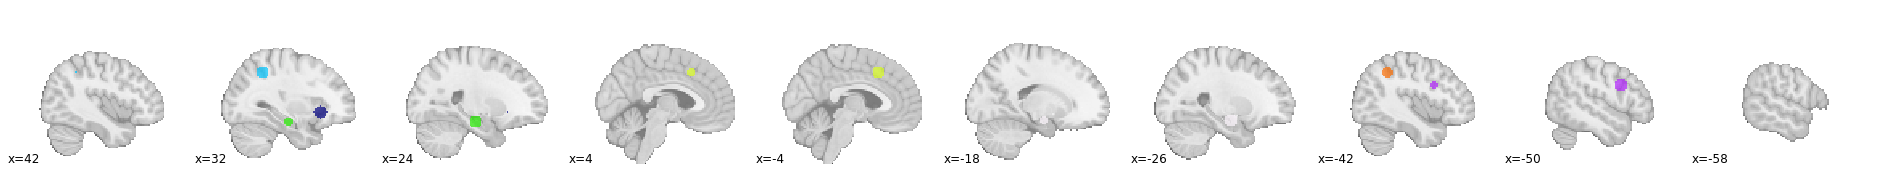

In [9]:
import numpy as np

base_dir = '/Users/TienTong/Desktop/utdallas_demo'
atlas_filename = base_dir + '/code/neurosynth/memory_peak.nii.gz'
atlas = pd.read_csv(base_dir + '/code/neurosynth/memory_peak.txt', sep = '\t')
labels = list(atlas.regions)
coords = np.array(atlas[['x', 'y', 'z']])

from nilearn import plotting
plotting.plot_roi(atlas_filename, display_mode='x', cut_coords=10)
atlas


### Extract beta series from Memory ROIs, then calculate correlation matrices

In [10]:
# BETA SERIES EXTRACTION
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

face_betas_extracted = masker.fit_transform(face_betas_smooth)
scene_betas_extracted = masker.fit_transform(scene_betas_smooth)
lexdec_betas_extracted = masker.fit_transform(lexdec_betas_smooth)


# CORRELATION
from nilearn.connectome import ConnectivityMeasure
# Plot the correlation matrix
import numpy as np
from nilearn import plotting

correlation_measure = ConnectivityMeasure(kind='correlation')
face_correlation_matrix = correlation_measure.fit_transform([face_betas_extracted])[0]
scene_correlation_matrix = correlation_measure.fit_transform([scene_betas_extracted])[0]
lexdec_correlation_matrix = correlation_measure.fit_transform([lexdec_betas_extracted])[0]

# Memory ROIs Correlation: Face Prospective Memory

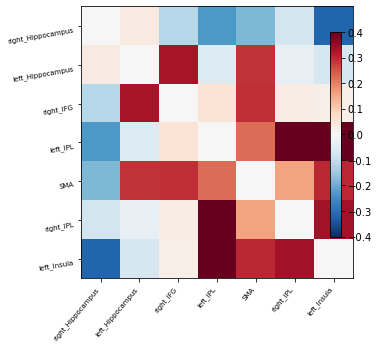

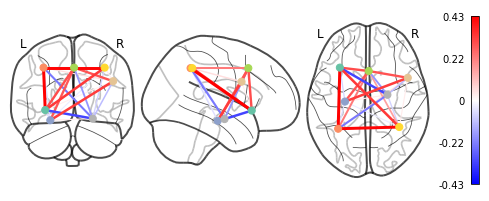

In [11]:
# Mask the main diagonal for visualization:
np.fill_diagonal(face_correlation_matrix, 0)
plotting.plot_matrix(face_correlation_matrix, vmax=0.4, vmin=-0.4, reorder=True, labels=labels, colorbar=True)
plotting.plot_connectome(face_correlation_matrix, coords, colorbar=True)

# Memory ROIs Correlation: Scene Prospective Memory

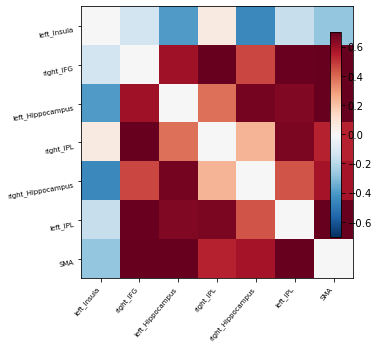

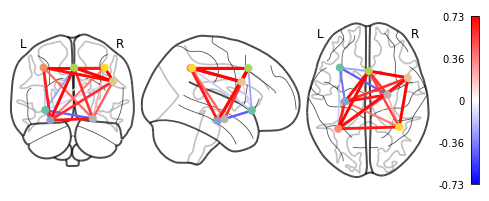

In [12]:
np.fill_diagonal(scene_correlation_matrix, 0)
plotting.plot_matrix(scene_correlation_matrix, vmax=0.7, vmin=-0.7, reorder=True, labels=labels, colorbar=True)
plotting.plot_connectome(scene_correlation_matrix, coords, colorbar=True)

# Memory ROIs Correlation: 2-back lexical decision

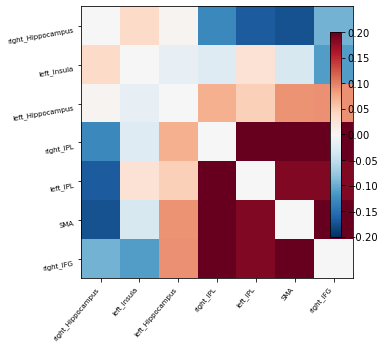

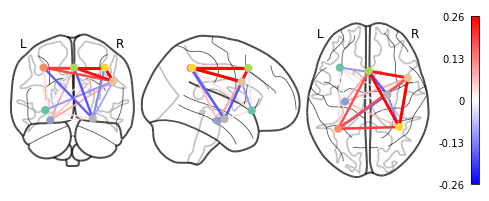

In [13]:
np.fill_diagonal(lexdec_correlation_matrix, 0)
plotting.plot_matrix(lexdec_correlation_matrix, vmax=0.2, vmin=-0.2, reorder=True, labels=labels, colorbar=True)
plotting.plot_connectome(lexdec_correlation_matrix, coords, colorbar=True)

# NiBetaSeries (Not using due to pybids compatibility issues)

Code: [NiBetaSeries tutorial](https://nibetaseries.readthedocs.io/en/stable/auto_examples/plot_run_nibetaseries.html#sphx-glr-auto-examples-plot-run-nibetaseries-py), written by James Kent.

```
docker pull hbclab/nibetaseries:v0.6.0
```

In [ ]:
# %%bash

# ###################################################################
# ################ TRY RUNNING USING CLI OF nibs ####################
# ###################################################################

# import tempfile  # make a temporary directory for files
# import os  # interact with the filesystem
# import urllib.request  # grad data from internet
# import tarfile  # extract files from tar
# from subprocess import Popen, PIPE, STDOUT  # enable calling commandline

# import matplotlib.pyplot as plt  # manipulate figures
# import seaborn as sns  # display results
# import pandas as pd   # manipulate tabular data
# import nibabel as nib  # load the beta maps in python
# from nilearn import plotting  # plot nifti images

# import os
# atlas_mni_file = "/memory_peak.nii.gz"
# atlas_tsv = "/atlas.tsv"

# cmd = """\
# nibs -c WhiteMatter CSF \
# --participant-label 01 \
# --estimator lsa \
# --hrf-model glover \
# -w {work_dir} \
# -a {atlas_mni_file} \
# -l {atlas_tsv} \
# {bids_dir} \
# {fmriprep_dir} \
# {out_dir} \
# participant
# """.format(atlas_mni_file=atlas_mni_file,
#            atlas_tsv=atlas_tsv,
#            bids_dir="/base_dir/data",
#            fmriprep_dir="/base_dir/derivatives/fmriprep",
#            out_dir="/out_dir",
#            work_dir="/out_dir")

# # Since we cannot run bash commands inside this tutorial
# # we are printing the actual bash command so you can see it
# # in the output
# print("The Example Command:\n", cmd)

# # call nibs
# p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)

# while True:
#     line = p.stdout.readline()
#     if not line:
#         break
#     print(line)

# ###################################################################
# #################### TRY RUNNING USING DOCKER #####################
# ###################################################################

# base_dir=/Users/TienTong/Desktop/utdallas_demo
# out_dir=$base_dir/derivatives/nibetaseries
# atlas_mni_file=$base_dir/code/neurosynth/memory_peak.nii.gz
# atlas_tsv=$base_dir/code/neurosynth/atlas.tsv

# docker run -it --rm -v $base_dir:/base_dir \
#                      -v $out_dir:/out_dir  \
#                      -v $out_dir:/work_dir \
#                      -v $atlas_mni_file:/memory_peak.nii.gz \
#                      -v $atlas_tsv:/atlas.tsv \
#                      -v $base_dir/dataset_description.json:/base_dir/data/dataset_description.json \
#                      hbclab/nibetaseries:v0.6.0 \
#                      nibs -c WhiteMatter CSF \
#                            --participant-label 01 \
#                            -w /work_dir \
#                            -a /memory_peak.nii.gz \
#                            -l /atlas.tsv \
#                            -t em \
#                            --run-label 1 \
#                            /base_dir/data \
#                            /base_dir/derivatives/fmriprep \
#                            /out_dir \
#                            participant
                           
# ###################################################################
# ########## TRY RUNNING FROM INSIDE THE DOCKER CONTAINER ###########
# ###################################################################                           

# base_dir=/Users/TienTong/Desktop/utdallas_demo
# out_dir=$base_dir/derivatives/nibetaseries
# atlas_mni_file=$base_dir/code/neurosynth/memory_peak.nii.gz
# atlas_tsv=$base_dir/code/neurosynth/atlas.tsv

# docker run -it --rm -v $base_dir:/base_dir \
#                      -v $out_dir:/out_dir  \
#                      -v $out_dir:/work_dir \
#                      -v $atlas_mni_file:/memory_peak.nii.gz \
#                      -v $atlas_tsv:/atlas.tsv \
#                      hbclab/nibetaseries:v0.6.0
                     
# ###################################################################
# ########## TRY RUNNING FROM CODE DOWNLOAD FROM GITHUB #############
# ###################################################################

# base_dir=/Users/TienTong/Desktop/utdallas_demo
# out_dir=$base_dir/derivatives/nibetaseries
# atlas_mni_file=$base_dir/code/neurosynth/memory_peak.nii.gz
# atlas_tsv=$base_dir/code/neurosynth/atlas.tsv

# cd ~/Desktop/utdallas_demo/code/NiBetaSeries-master/src/nibetaseries

# cli/run.py -c WhiteMatter CSF \
#    --participant-label 01 \
#    -w /work_dir \
#    -a $atlas_mni_file \
#    -l $atlas_tsv \
#    -t em \
#    --run-label 1 \
#    $base_dir/data \
#    $base_dir/derivatives/fmriprep \
#    $out_dir \
#    participant